<font size="5">Importing Libraries</font>

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, f1_score

<font size="5">Constants for preprocessing</font>

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

DATA_DIR = 'brain-tumor-dataset'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MASKS_DIR = os.path.join(DATA_DIR, 'masks')

<font size="5">Load Dataset</font>

The dataset consists of 3064 brain mri images consisting of original images and masks

In [3]:
print("Loading and preprocessing data...")
image_files = sorted(os.listdir(IMAGES_DIR))
mask_files = sorted(os.listdir(MASKS_DIR))

print(f"Total number of images: {len(image_files)}")
print(f"Total number of masks: {len(mask_files)}")

X = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(mask_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int32)

for idx, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
    img_path = os.path.join(IMAGES_DIR, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X[idx] = img / 255.0
    
    mask_path = os.path.join(MASKS_DIR, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = np.expand_dims(mask > 0, axis=-1)
    y[idx] = mask

Loading and preprocessing data...
Total number of images: 3064
Total number of masks: 3064


<font size="5">Visualizing the Sample Images</font>

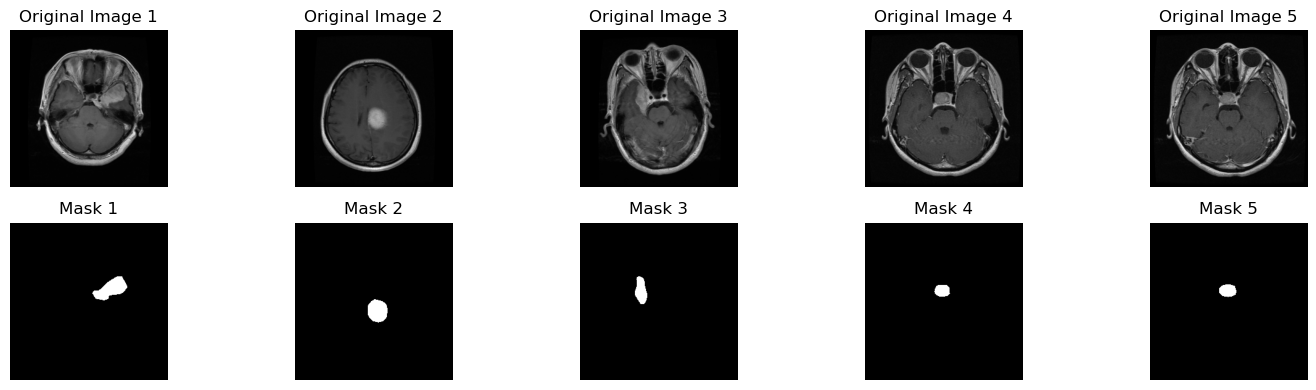

In [4]:
plt.figure(figsize=(15, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(y[i].squeeze(), cmap='gray')
    plt.title(f'Mask {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

<font size="5">Analyzing Tumor Sizes</font>

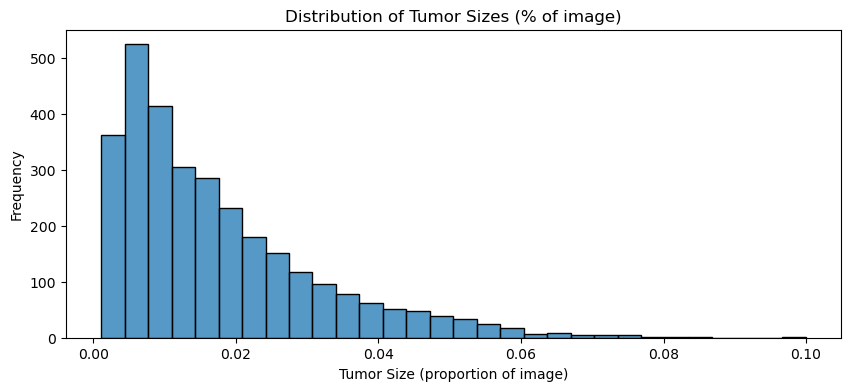

Average tumor size: 1.75% of image
Median tumor size: 1.34% of image
Max tumor size: 9.99% of image
Min tumor size: 0.11% of image


In [5]:
tumor_sizes = [np.sum(mask) / (IMG_WIDTH * IMG_HEIGHT) for mask in y]

plt.figure(figsize=(10, 4))
sns.histplot(tumor_sizes, bins=30)
plt.title('Distribution of Tumor Sizes (% of image)')
plt.xlabel('Tumor Size (proportion of image)')
plt.ylabel('Frequency')
plt.show()

print(f"Average tumor size: {np.mean(tumor_sizes):.2%} of image")
print(f"Median tumor size: {np.median(tumor_sizes):.2%} of image")
print(f"Max tumor size: {np.max(tumor_sizes):.2%} of image")
print(f"Min tumor size: {np.min(tumor_sizes):.2%} of image")

<font size="5">Splitting Dataset into Test and Train</font>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 2451
Testing set size: 613


<font size="5">Creating the unet model</font>

In [7]:
input_layer = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Encoder
c1 = Conv2D(16, 3, activation='relu', padding='same')(input_layer)
p1 = MaxPooling2D()(c1)

c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
p2 = MaxPooling2D()(c2)

c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
p3 = MaxPooling2D()(c3)

# Bridge
c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)

# Decoder
u5 = Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)

u6 = Conv2DTranspose(32, 2, strides=2, padding='same')(c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)

u7 = Conv2DTranspose(16, 2, strides=2, padding='same')(c6)
u7 = concatenate([u7, c1])
c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)

outputs = Conv2D(1, 1, activation='sigmoid')(c7)

model = Model(inputs=[input_layer], outputs=[outputs])

<font size="5">Compile and Train Model</font>

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

Epoch 1/10


c:\Users\Aashish\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 118s 708ms/step - accuracy: 0.9798 - auc: 0.5565 - loss: 0.2056 - precision: 1.9696e-04 - recall: 3.9080e-05 - val_accuracy: 0.9819 - val_auc: 0.8591 - val_loss: 0.0725 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 106s 686ms/step - accuracy: 0.9831 - auc: 0.8548 - loss: 0.0684 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9819 - val_auc: 0.8942 - val_loss: 0.0701 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 106s 688ms/step - accuracy: 0.9824 - auc: 0.8926 - loss: 0.0652 - precision: 0.2588 - recall: 0.0023 - val_accuracy: 0.9827 - val_auc: 0.9317 - val_loss: 0.0603 - val_precision: 0.6520 - val_recall: 0.0901 - learning_rate: 0.0010
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 108s 700ms/step - accuracy: 0.9833 - auc: 0.9249 - loss: 0.0574 - precision: 0.6960 - recall: 0.0749 - val_accuracy: 0.9836 - val

<font size="5">Plotting training history</font>

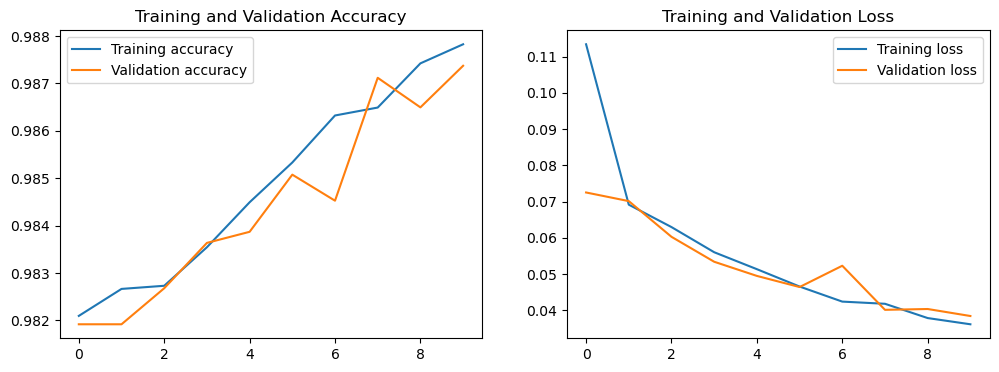

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step

Model Performance Metrics:
Test Accuracy: 0.9874
Precision: 0.8571
Recall/Sensitivity: 0.3618
Specificity: 0.9989
F1 Score: 0.5088
IoU Score: 0.3412
ROC AUC: 0.9784
PR AUC: 0.6471


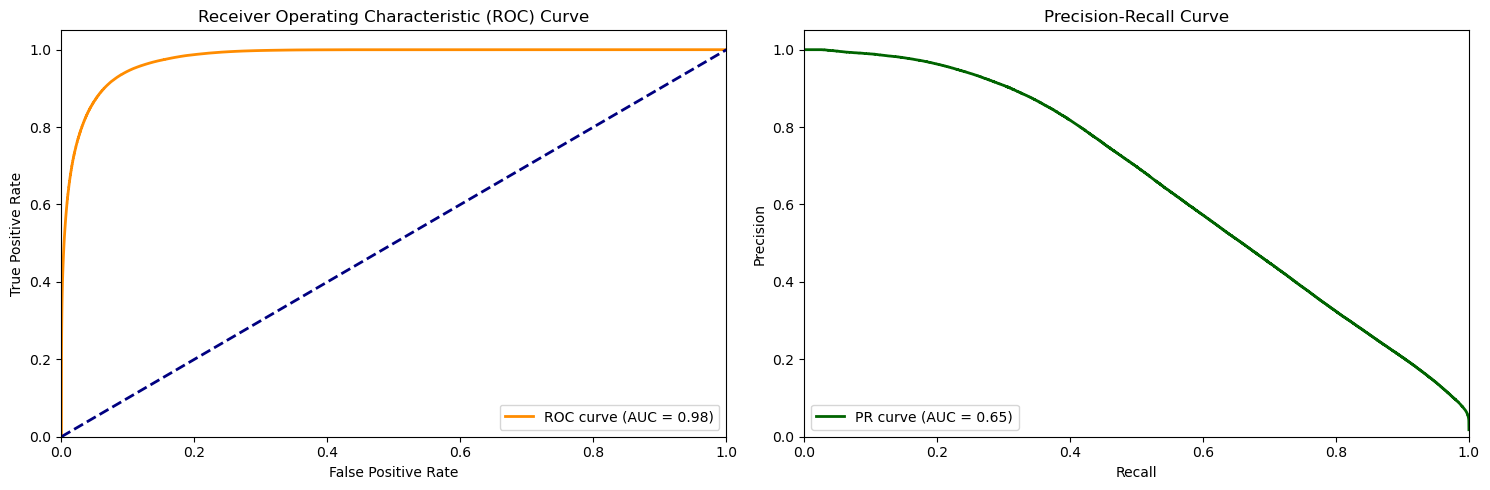

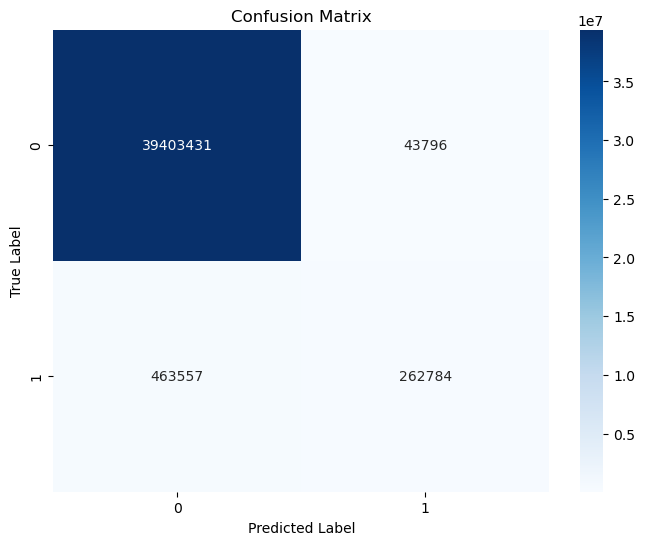

In [10]:
predictions = model.predict(X_test)

# Convert predictions to binary using threshold
binary_predictions = (predictions > 0.5).astype(np.uint8)

# Flatten the masks for metric calculation
y_true_flat = y_test.reshape(-1)
y_pred_flat = binary_predictions.reshape(-1)
y_pred_prob_flat = predictions.reshape(-1)

# Calculate basic metrics
tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat).ravel()

# Calculate advanced metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = f1_score(y_true_flat, y_pred_flat)

# Calculate IoU (Intersection over Union)
intersection = np.logical_and(y_test, binary_predictions)
union = np.logical_or(y_test, binary_predictions)
iou = np.mean(np.sum(intersection) / np.sum(union))

# Calculate ROC and PR curves
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_prob_flat)
roc_auc = auc(fpr, tpr)

precision_curve, recall_curve, _ = precision_recall_curve(y_true_flat, y_pred_prob_flat)
pr_auc = auc(recall_curve, precision_curve)

# Print metrics
print("\nModel Performance Metrics:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU Score: {iou:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Plot ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Precision-Recall Curve
ax2.plot(recall_curve, precision_curve, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true_flat, y_pred_flat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

<font size="5">Visualizing Predictions</font>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


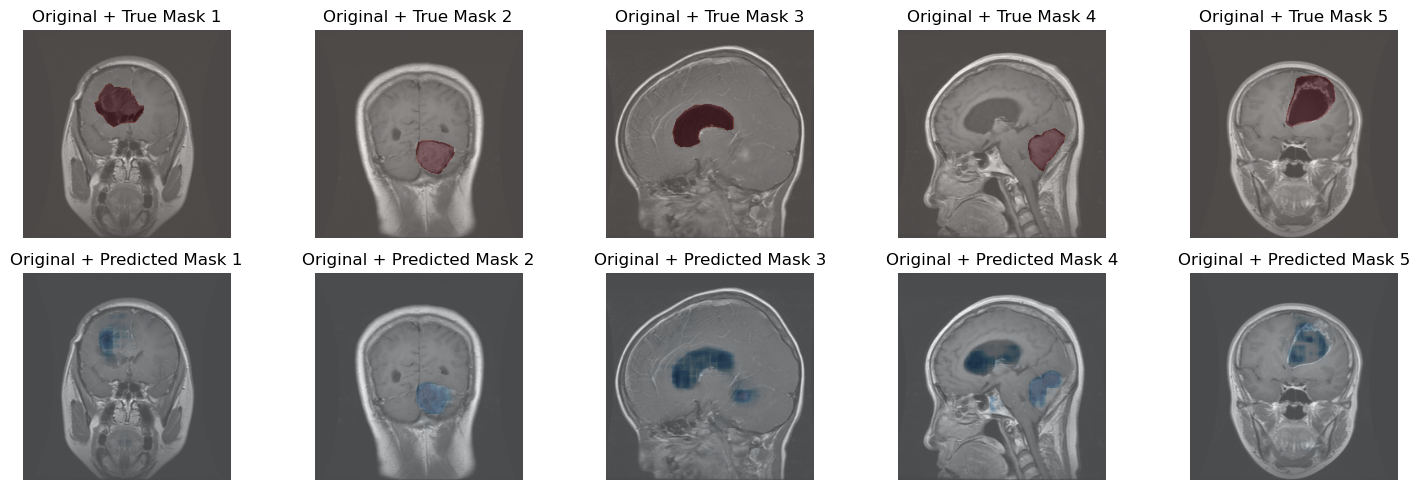

In [11]:
num_samples = 5

predictions = model.predict(X_test[:num_samples])

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    # Original image with true mask overlay
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(X_test[i])
    plt.imshow(y_test[i].squeeze(), alpha=0.3, cmap='Reds')
    plt.title(f'Original + True Mask {i+1}')
    plt.axis('off')
    
    # Original image with predicted mask overlay
    plt.subplot(2, num_samples, i + num_samples + 1)
    plt.imshow(X_test[i])
    plt.imshow(predictions[i].squeeze(), alpha=0.3, cmap='Blues')
    plt.title(f'Original + Predicted Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()